In [0]:
import gym 
import time
import numpy as np
import matplotlib.pyplot as plt

In [120]:
np.random.seed(5467)
env = gym.make('FrozenLake-v0',desc=None,map_name='4x4')
env.seed(48304)
env._max_episode_steps = 1000
env.render()


SFFF
FHFH
FFFH
HFFG


In [0]:
nA=env.nA
nS=env.nS

http://www.jmlr.org/papers/volume10/strehl09a/strehl09a.pdf

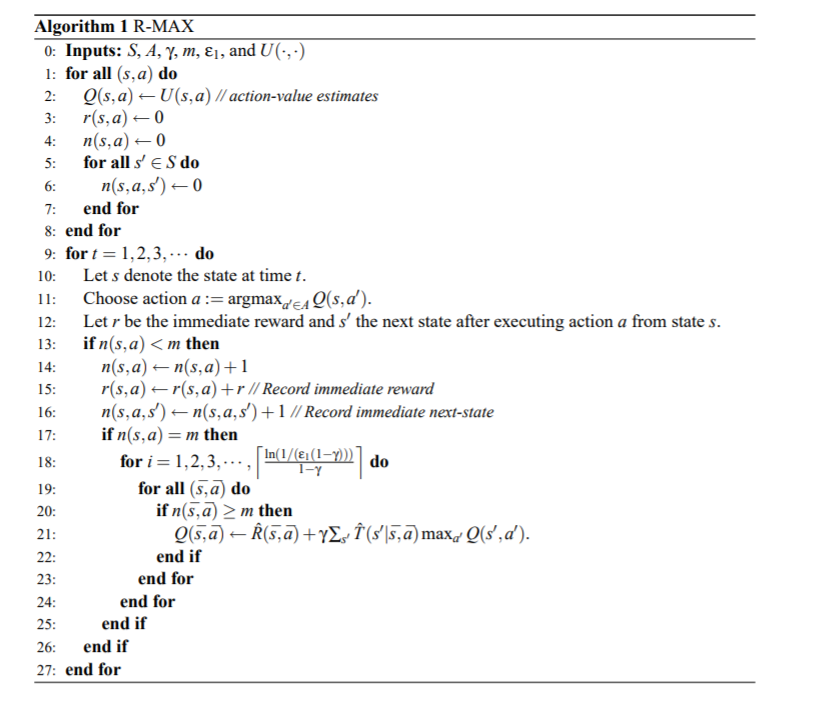

In [0]:
class RmaxAgent:

    def __init__(self,env, R_max, gamma, max_visits_per_state, max_episodes, max_steps, epsilon = 0.2):
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_steps = max_steps
        self.max_visits_per_state = max_visits_per_state
        self.max_episodes = max_episodes
        self.Q = np.ones((env.nS, env.nA)) * R_max / (1 - self.gamma)
        # self.Q = np.random.random((env.nS, env.nA))
        self.R = np.zeros((env.nS, env.nA))  #Slide 33 of this Stanford ppt suggested this change and it worked pretty well 
        #https://web.stanford.edu/class/cs234/slides/2017/lecture10_sample_efficiency.pdf
        self.nSA = np.zeros((env.nS, env.nA))
        self.nSAS = np.zeros((env.nS, env.nA, env.nS))
        self.val1 = []
        self.val2 = []  #This is for keeping track of rewards over time and for plotting purposes  
        print(int( np.ceil(np.log(1 / (self.epsilon * (1-self.gamma))) / (1-self.gamma))))

    def estimate_transition_probablities(self):

        for episode in range(self.max_episodes):

            obs = env.reset()
            if(episode % 20 == 0):
                self.val1.append(self.mean_rewards_per_500())
                self.val2.append(episode)            
            

            for step in range(self.max_steps):

                best_action = self.choose_action(obs)
                new_obs, reward, done, _ = env.step(best_action)
                #print(obs)
                if self.nSA[obs][best_action] < self.max_visits_per_state :

                    self.nSA[obs][best_action] +=1
                    self.R[obs][best_action] += reward
                    self.nSAS[obs][best_action][new_obs] += 1

                    if self.nSA[obs][best_action] == self.max_visits_per_state:

                        for i in range(int( np.ceil(np.log(1 / (self.epsilon * (1-self.gamma))) / (1-self.gamma)) )):

                            for state in range(env.nS):
                                
                                for action in range(env.nA):

                                    if self.nSA[state][action] >= self.max_visits_per_state:
                                        
                                        #In the cited paper it is given that reward[s,a]= summation of rewards / nSA[s,a]
                                        #We have already calculated the summation of rewards in line 28
                                        q = (self.R[state][action]/self.nSA[state][action])

                                        
                                        for next_state in range(env.nS):
                                            
                                            #In the cited paper it is given that transition[s,a] = nSAS'[s,a,s']/nSA[s,a]

                                            transition = self.nSAS[state][action][next_state]/self.nSA[state][action]
                                            q += (transition * np.max(self.Q[next_state,:]))

                                        self.Q[state][action] = q 
                                        #print(q + self.gamma*(self.R[state][action]/self.nSA[state][action]))
                                        #In the cited paper it is given that reward[s,a]= summation of rewards / nSA[s,a]
                                        #We have already calculated the summation of rewards in line 28
                
               
                if done:
                    if not(reward==1):
                        self.R[obs][best_action]=-10

                    break

                obs = new_obs



                          

    def mean_rewards_per_500(self):
        
        total_reward = 0
        for episodes in range(500):
            observation = env.reset()
            for _ in range(1000):

                action = self.choose_action(observation)
                observation, reward, done, info = env.step(action)
                total_reward += reward
                if done:
                    observation = env.reset()
                    break
        return (total_reward/500) 

    def choose_action(self,observation):
        if np.random.random() > (1-self.epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(self.Q[observation])
        return action

In [214]:
rmaxagent = RmaxAgent(env, 1 , 0.98, 25, 50000, 10)
rmaxagent.estimate_transition_probablities()

277


Text(0.5, 1.0, 'R-Max on a 4x4 environment')

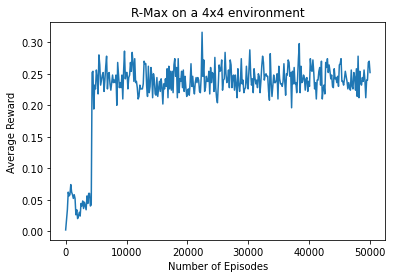

In [217]:
plt.plot(rmaxagent.val2[::7],rmaxagent.val1[::7])
plt.xlabel("Number of Episodes")
plt.ylabel("Average Reward")
plt.title("R-Max on a 4x4 environment")